# Neural Network Training Template (PyTorch)

This notebook provides a template for training a neural network using PyTorch.

---

## 1. Dataset Loading and Preparation

In [1]:
import os
import re
import imutils
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
import pytesseract
import cv2
import io

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


C:\Users\stavc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

In [3]:
# Load train and test sets to pandas
hugging_face_train_df = hugging_face_ds["train"].to_pandas()
hugging_face_test_df = hugging_face_ds["test"].to_pandas()

In [4]:
# Convert ID's to numeric
hugging_face_train_df["id"] = pd.to_numeric(hugging_face_train_df["id"])
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

In [9]:
# Build standard columns for textual prompt and a boolean label weather the content is harmful
def build_textual_prompt_object(df):
    if 'conversations' in df.columns:
        all_conversations = list(df['conversations'])
        df['textual_prompt'] = [item[0]['value'] for item in all_conversations]
        df['is_harmful'] = [item[1]['value'] for item in all_conversations]
        df['is_harmful'] = df['is_harmful'].eq('Yes').mul(True)
        
build_textual_prompt_object(hugging_face_train_df)
build_textual_prompt_object(hugging_face_test_df)

In [12]:
def get_image_text(df):
    list_image_texts = []
    if 'image_text' in df.columns:
        return df['image_text']
    
    for prompt in df['textual_prompt']:
        match = re.search(r'The text in the meme is: (.*?)\.\n<image>\n', prompt)
        if match:
            list_image_texts.append(match.group(1))
        else:
            list_image_texts.append('')
    return list_image_texts

hugging_face_train_df['image_text'] = get_image_text(hugging_face_train_df)
hugging_face_test_df['image_text'] = get_image_text(hugging_face_test_df)

In [13]:
# Save all images bytes in files and save in the dataframe the image path 
os.makedirs('images', exist_ok=True)

def build_images_column(df):
    if 'image_path' in df.columns:
        return df['image_path']
        
    list_paths = []
    for image in df['image']:
        save_path = f'images/{image['path']}'
        list_paths.append(save_path)
        
        if not os.path.exists(save_path):
            with open(save_path, 'wb') as f:
                f.write(image['bytes'])
    return list_paths

hugging_face_train_df['image_path'] = build_images_column(hugging_face_train_df)
hugging_face_test_df['image_path'] = build_images_column(hugging_face_test_df)

In [14]:
# Remove not used columns after being proccesed
hugging_face_train_df = hugging_face_train_df.drop(columns=['image', 'conversations'], errors='ignore')
hugging_face_test_df = hugging_face_test_df.drop(columns=['image', 'conversations'], errors='ignore')

In [15]:
hugging_face_train_df.head()

,id,textual_prompt,is_harmful,image_text,image_path
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png


In [17]:
hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_text.values[0]

'when your human says "who\' s a good girl?" and you already know it\'s you'

In [18]:
hugging_face_test_df.head()

,id,textual_prompt,is_harmful,image_text,image_path
0,1268,A direct or indirect attack on people based on...,False,father and daughter bonding time is the best l...,images/01268.png
1,1456,A direct or indirect attack on people based on...,True,they see them rollin..... they hating..,images/01456.png
2,1726,A direct or indirect attack on people based on...,True,a real man loads the dishwasher every night,images/01726.png
3,1742,A direct or indirect attack on people based on...,False,in just one hour from now i'll only have 4 hou...,images/01742.png
4,1765,A direct or indirect attack on people based on...,True,"after a girl dies, what organ in her body stay...",images/01765.png


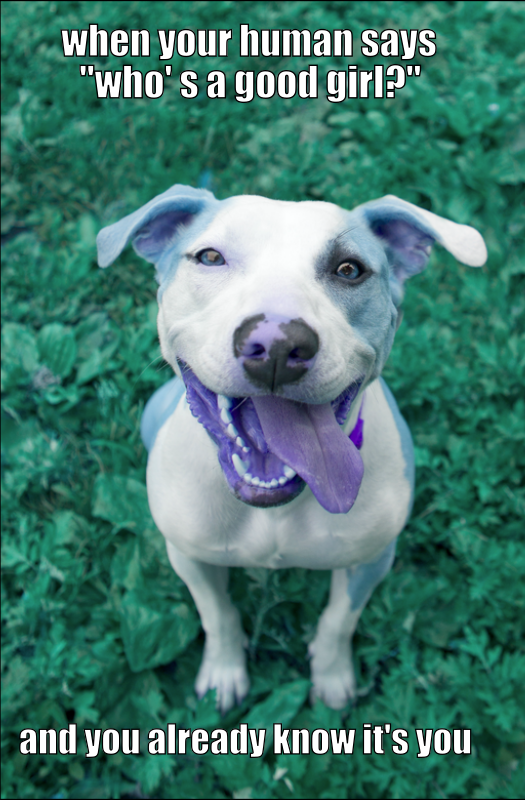

In [20]:
sample_image = cv2.imread('images/01243.png')
pil_img = Image.fromarray(sample_image)
display(pil_img)

In [21]:
extracted_text = pytesseract.image_to_string(sample_image, config='--psm 3')
extracted_text

"a * te\nWhen your human: says: “%\n_ “who's agood girls — ei\n\not ors\n4 nt\n\nhe >\n—\n\nand you already know it's you\n"

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Example: Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Visualize some samples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
plt.figure(figsize=(8, 2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f'Label: {example_targets[i].item()}')
    plt.axis('off')
plt.show()

## 2. Neural Network Class (PyTorch)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = SimpleNN()

## 3. Training and Evaluation

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

## 4. Results Visualization

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()